# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.special import softmax
import pandas as pd 
import csv
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable as V
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch import nn

from utils.progress_bar import progress_bar

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"PyTorch version = {torch.__version__}\n")

/Users/niccolomeniconi/opt/anaconda3/envs/conductor/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PyTorch version = 2.0.0



File length: 250
Sample window: 250
Number of Recordings: 1



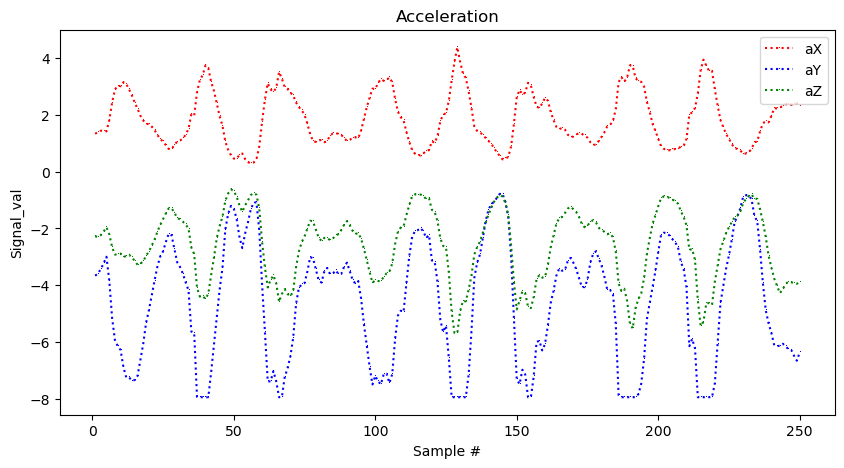

In [2]:
subj = 'N'
act = 'flower'
trial = '4'
data_folder = f"../data_collection/{act}/"
filename = f"{subj}_trial{trial}.csv"
df = pd.read_csv(data_folder + filename)

file_len = len(df['aX'])
window_len = 250  #~120

recording_num = file_len//window_len
print("File length: "+str(file_len))
print("Sample window: "+str(window_len))
print("Number of Recordings: "+str(recording_num)+"\n")

### Check sample in dataset ###

index = range(1, len(df['aX'])+1)

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(index, df['aX'], 'r', label='aX', linestyle='dotted', marker=',')
plt.plot(index, df['aY'], 'b', label='aY', linestyle='dotted', marker=',')
plt.plot(index, df['aZ'], 'g', label='aZ', linestyle='dotted', marker=',')


plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Signal_val")
plt.legend()
plt.show()

# Parse and Prepare data

### Pre-process threshold windows to make new set of training windows

In [3]:
data_folder = f"../data_collection/"

GESTURES = ['still', 'overhead', 'butterfly', 'flower'] 

SUBJECTS = [
  'N'
]

TRIALS = 40
SAMPLES_PER_GESTURE = 30
window_len=SAMPLES_PER_GESTURE

# create a one-hot encoded matrix that is used in the output
NUM_GESTURES = len(GESTURES)
print("NUM GESTURES:", NUM_GESTURES)
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
print("ONE HOT ENCODED GESTURES SHAPE:", ONE_HOT_ENCODED_GESTURES.shape)

inputs = []
outputs = []

###########################################

for gesture_index in range(NUM_GESTURES):
  for subject_index in range(len(SUBJECTS)):
    for trial_idx in range(TRIALS):

      gesture = GESTURES[gesture_index]
      subject = SUBJECTS[subject_index]
      print(f"Processing index {gesture_index} for gesture '{gesture}' for subject '{subject}'.")
      print(f's_ix: {subject_index}, gesture_ix: {gesture_index}, trial_ix: {trial_idx}')

      output = ONE_HOT_ENCODED_GESTURES[gesture_index]

      # df_pth = data_folder + gesture + subject + "_thresh_act" + str(gesture_index) + "_trial" + str(trial_idx) + ".csv"
      filename = f"{gesture}/{subj}_trial{str(trial_idx)}.csv"
      # df_pth = pd.read_csv(data_folder + filename)
      print(filename)
      print(data_folder)
      df = pd.read_csv(data_folder + filename)
      
      # calculate the number of gesture recordings in the file
      num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
      
      # print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
      
      for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
          index = i * SAMPLES_PER_GESTURE + j

          tensor += [
              ((df['aX'][index]) ,
              (df['aY'][index]),
              (df['aZ'][index]),
              (df['gX'][index]),
              (df['gY'][index]),
              (df['gZ'][index])),
          ]


        inputs.append(tensor)
        outputs.append(output)

# convert the list to numpy array
inputs = np.around(np.array(inputs), decimals=3)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

NUM GESTURES: 4
ONE HOT ENCODED GESTURES SHAPE: (4, 4)
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 0
still/N_trial0.csv
../data_collection/
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 1
still/N_trial1.csv
../data_collection/
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 2
still/N_trial2.csv
../data_collection/
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 3
still/N_trial3.csv
../data_collection/
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 4
still/N_trial4.csv
../data_collection/
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 5
still/N_trial5.csv
../data_collection/
Processing index 0 for gesture 'still' for subject 'N'.
s_ix: 0, gesture_ix: 0, trial_ix: 6
still/N_trial6.csv
../data_collection/
Processing index 0 for gestu

In [4]:
# Check data structure to normalize and set the data correctly

print("inputs shape:", inputs.shape)
print("outputs shape:", outputs.shape)

print('aX, aY, aZ OG:')
print('MAX:', np.max(inputs[:3]))
print('MIN:', np.min(inputs[:3]))
print('MEAN:', np.mean(inputs[:3]), '\n')

print('gX, gY, gZ OG:')
print('MAX:', np.max(inputs[3:]))
print('MIN:', np.min(inputs[3:]))
print('MEAN:', np.mean(inputs[3:]))

print("NORMALIZE")

inputs_a = inputs[:3]
inputs_g = inputs[3:]

mean_a = np.mean(inputs_a)
mean_g = np.mean(inputs_g)
std_a = np.std(inputs_a)
std_g = np.std(inputs_g)

inputs[:3] = (inputs[:3] - mean_a) / (std_a)
inputs[3:] = (inputs[3:] - mean_g) / (std_g)

print('aX, aY, aZ OG:')
print('MAX:', np.max(inputs[:3]))
print('MIN:', np.min(inputs[:3]))
print('MEAN:', np.mean(inputs[:3]))
print('STD:', np.std(inputs[:3]), '\n')

print('gX, gY, gZ OG:')
print('MAX:', np.max(inputs[3:]))
print('MIN:', np.min(inputs[3:]))
print('MEAN:', np.mean(inputs[3:]))
print('STD:', np.std(inputs[3:]), '\n')


inputs shape: (1280, 30, 6)
outputs shape: (1280, 4)
aX, aY, aZ OG:
MAX: 1.028
MIN: -0.966
MEAN: -0.15726851851851853 

gX, gY, gZ OG:
MAX: 1371.592
MIN: -1440.346
MEAN: 2.700706769337857
NORMALIZE
aX, aY, aZ OG:
MAX: 2.6509824954026504
MIN: -1.808816287104451
MEAN: -1.6447748512965283e-18
STD: 1.0 

gX, gY, gZ OG:
MAX: 5.179450586105771
MIN: -5.4600311566851545
MEAN: -1.100466431439118e-17
STD: 1.0 



In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation

num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.8 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs)

inputs_train, inputs_test = np.split(inputs, [TRAIN_SPLIT])
outputs_train, outputs_test = np.split(outputs, [TRAIN_SPLIT])


inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


# Dataloader

In [6]:
train_set = []
test_set = []

x_train = inputs_train
x_test = inputs_test
train_label = outputs_train
test_label = outputs_test

In [7]:
simple_transform = transforms.Compose([transforms.ToTensor()])

for idx, input_data in enumerate(x_train):
    trdata1 = V(simple_transform(input_data)).float().squeeze(1)
    train_set.append([trdata1, V(torch.FloatTensor(train_label[idx]))]) 

for idx, tsdata in enumerate(x_test):
    tsdata1 = V(simple_transform(tsdata)).float().squeeze(1)
    test_set.append([tsdata1, V(torch.FloatTensor(test_label[idx]))]) 

trainloader = torch.utils.data.DataLoader(train_set, batch_size=10, num_workers=2,
                                            pin_memory=True, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=2,
                                            pin_memory=True, shuffle=False)


In [8]:
images, labels = next(iter(trainloader))
print('images[0].shape: ', images[0].shape)
print('labels[0].shape: ', labels[0].shape, '\n')
# Check if it matches up with format from SCH files
print(torch.max(images), torch.min(images))
print(torch.max(labels), torch.min(labels))
print(labels)
# blabla

images[0].shape:  torch.Size([6, 30])
labels[0].shape:  torch.Size([4]) 

tensor(3.1265) tensor(-3.1606)
tensor(1.) tensor(0.)
tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])


In [9]:
# Save mean and std array values
mean_and_std={'mean':[mean_a, mean_g],'std':[std_a, std_g]}
out_pth = './utils/models'
mean_std_out_pth = f"{out_pth}/mean_and_std_{len(GESTURES)}.csv" 
with open(mean_std_out_pth, "w", newline="") as fp:
    writer = csv.DictWriter(fp, fieldnames=mean_and_std.keys())
    writer.writeheader()
    writer.writerow(mean_and_std)
    print(f"Mean and STD saved to {mean_std_out_pth}")

Mean and STD saved to ./utils/models/mean_and_std_4.csv


# Training

In [10]:
import os
os.getcwd()

'/Users/niccolomeniconi/Dropbox (ASU)/Mac/Documents/Arduino/MFG598_project/main'

In [11]:
# # Training imports
# import torch.optim as optim
# import torch.utils.data
# import torch.backends.cudnn as cudnn
# import torchvision
# from torchvision import transforms as transforms
# from torch import nn

# from utils.progress_bar import progress_bar
# import numpy as np

In [12]:
class Encoder1d_conduct(nn.Module): # has same conv layers as CNN_3d
    
    def __init__(self, window_len, verbose):
        super().__init__()

        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(6*30, 125),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(125, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x_in, verbose = False):
        if verbose: print('x_in shape:', x_in.shape)
        
        x_fl = self.flatten(x_in)
        x_fl = torch.unsqueeze(x_fl, 1)
        if verbose: print('x_fl shape:', x_fl.shape)

        x_lin = self.encoder_lin(x_fl)

        x_out = x_lin
        if verbose: print("x_out shape:", x_out.shape)

        return x_out

In [13]:
class DecoderLin1d_conduct(nn.Module):
    
    def __init__(self, window_len, verbose, number_activities):
        super().__init__()

            ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(32, 16),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(16, number_activities), 
            )
    def forward(self, x_in, verbose = False):
        if verbose: print('decoder input shape:', x_in.shape)
        x_dec = self.decoder_lin(x_in)
        if verbose: print('x_dec shape:', x_dec.shape)

        x = torch.sigmoid(x_dec)
        x_uns = torch.squeeze(x, 1)
        x_out = x_uns

        if verbose: print("x_out shape:", x_out.shape)
        
        return x_out

In [15]:
# Training params
epochs = 75
lr = 1e-4

if torch.cuda.is_available(): device = torch.device('cuda')
else:                         device = torch.device('cpu')

encoder = Encoder1d_conduct(window_len = window_len, verbose=True).to(device)
decoder = DecoderLin1d_conduct(window_len = window_len, number_activities=len(GESTURES), verbose=True).to(device)


optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

In [16]:
def train(train_loader, progressbool = True):
    print("train:")
    encoder.train()
    decoder.train()
    train_loss = 0
    train_correct = 0
    total = 0

    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        encoded_data = encoder(data)
        output = decoder(encoded_data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # NUM_GESTURES = len(GESTURES)
        # ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES) 
        prediction_val, prediction_idx = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
        prediction = prediction_idx.detach().cpu().numpy()
        target_idx = np.where(target==1.)    
        total += target.size(0)

        train_correct += np.sum(prediction== target_idx[1]) 

        
        progress_bar(batch_num, len(train_loader), f'Loss: {np.round(train_loss / (batch_num + 1), 5)} | Acc: {100. * np.round((train_correct / total), 5)}% ({train_correct}/{total})')

    return train_loss, train_correct / total    

In [17]:
def test(test_loader, progressbool=True):
    print("test:")
    encoder.train()
    decoder.train()
    test_loss = 0
    test_correct = 0
    total = 0

    with torch.no_grad():
        for batch_num, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            encoded_data = encoder(data)
            output = decoder(encoded_data)
            loss = criterion(output, target)
            test_loss += loss.item()

            # # prediction = torch.max(output, 1)
            # NUM_GESTURES = len(GESTURES)
            # ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES) ###### INEFFICIENT  
            prediction_val, prediction_idx = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
            prediction = prediction_idx.detach().cpu().numpy()
            target_idx = np.where(target==1.)    
            total += target.size(0)
            # prediction = torch.max(torch.squeeze(output))
            # prediction = torch.nn.functional.softmax(output, dim = 2)

            test_correct += np.sum(prediction== target_idx[1]) 

            progress_bar(batch_num, len(test_loader), f'Loss: {np.round(test_loss / (batch_num + 1), 5)} | Acc: {100. * np.round((test_correct / total), 5)}% ({test_correct}/{total})')

    return test_loss, test_correct / total 
    #         if progressbool: progress_bar(batch_num, len(test_loader), f'Loss: {test_loss / (batch_num + 1)} | Acc: {100. * test_correct / total}% ({test_correct}/{total}')
    # return test_loss, test_correct / total

In [18]:
def save_best_loss(out_pth, test_result):
    enc_out_path = f"{out_pth}/best_FCN_{len(GESTURES)}_enc_model.pth" 
    dec_out_path = f"{out_pth}/best_FCN_{len(GESTURES)}_dec_model.pth" 
    print(enc_out_path)
    print(dec_out_path)
    torch.save(encoder.state_dict(), enc_out_path)
    torch.save(decoder.state_dict(), dec_out_path)
    print(f"BEST LOSS: {test_result[0]}")
    print(f"ACCURACY: {test_result[1]}" )
    print("Encoder saved to {}".format(enc_out_path))
    print("Decoder saved to {}".format(dec_out_path))

def save_best_acc(out_pth, test_result):
    enc_out_path = f"{out_pth}/best_FCN_{len(GESTURES)}_enc_model.pth" 
    dec_out_path = f"{out_pth}/best_FCN_{len(GESTURES)}_dec_model.pth" 
    print(enc_out_path)
    print(dec_out_path)
    torch.save(encoder.state_dict(), enc_out_path)
    torch.save(decoder.state_dict(), dec_out_path)
    print(f"BEST ACCURACT: {test_result[1]}")
    print(f"LOSS: {test_result[0]}" )
    print("Encoder saved to {}".format(enc_out_path))
    print("Decoder saved to {}".format(dec_out_path))

def save_final(out_pth, test_result):
    enc_out_path = f"{out_pth}/final_FCN_{len(GESTURES)}_enc_model.pth" 
    dec_out_path = f"{out_pth}/final_FCN_{len(GESTURES)}_dec_model.pth" 
    print(enc_out_path)
    print(dec_out_path)
    torch.save(encoder.state_dict(), enc_out_path)
    torch.save(decoder.state_dict(), dec_out_path)
    print(f"FINAL LOSS: {test_result[0]}")
    print(f"ACCURACY: {test_result[1]}" )
    print("Encoder saved to {}".format(enc_out_path))
    print("Decoder saved to {}".format(dec_out_path))

In [19]:
# Train model

accuracy = 0
history_da={'loss':[],'accuracy':[]}
best_acc = 0
for epoch in range(1, epochs + 1):
    print(f"\n===> epoch: {epoch}/{epochs}")

    train_result = train(trainloader, progressbool = True)
    # print(train_result)   
    test_result = test(testloader, progressbool = True)
    # scheduler.step(epoch)
    # current_lr = scheduler.get_last_lr()[0]
    accuracy = test_result[1]
    history_da['loss'].append(test_result[0])
    history_da['accuracy'].append(test_result[1])
    # print(f"**Learning Rate: {current_lr}")


    if epoch == 1:
        best_loss = test_result
        best_acc = test_result
    else:
        if test_result[0] >= best_loss[0]:
                # save_best(out_pth, test_result)
                best_loss = test_result
                # print("best_acc:", save_best_acc)
                save_best_loss(out_pth, best_loss)

        if test_result[1] >= best_acc[1]:
                # save_best(out_pth, test_result)
                best_acc = test_result
                # print("best_acc:", save_best_acc)
                save_best_acc(out_pth, best_acc)
            
    print(f"===> BEST ACC. PERFORMANCE: {str(np.round(best_acc[1]*100, 3))}")

    if epoch == epochs:
        print("===> FINAL ACC. PERFORMANCE: %.3f%%\n" % (test_result[1]*100))

        save_final(out_pth, test_result)
        history_out_pth = f"{out_pth}/FCN_{len(GESTURES)}_model_training_history.csv" 
        with open(history_out_pth, "w", newline="") as fp:
            writer = csv.DictWriter(fp, fieldnames=history_da.keys())
            writer.writeheader()
            writer.writerow(history_da)
            print(f"Training history saved to {history_out_pth}")  




===> epoch: 1/75
train:
 103/103 [===============================================================================>]  Step: 2ms | Tot: 328ms | Loss: 1.38013 | Acc: 33.137% (338/1020)% (334/1010)=======================================================>........................]  Step: 3ms | Tot: 228ms | Loss: 1.38323 | Acc: 26.901000000000003% (191/710) [================================================================================>]  Step: 3ms | Tot: 331ms | Loss: 1.37979 | Acc: 33.300999999999995% (341/1024)
test:
 26/26 [================================================================================>]  Step: 2ms | Tot: 58ms | Loss: 1.36788 | Acc: 47.656% (122/256)% (117/250)
===> BEST ACC. PERFORMANCE: 47.656

===> epoch: 2/75
train:
 103/103 [================================================================================>]  Step: 2ms | Tot: 369ms | Loss: 1.32677 | Acc: 50.488% (517/1024) (508/1010)===============================================================>................]  S

## Load saved model and model params 

In [20]:
model_dir = './utils/models'
best_enc_model =f'best_FCN_{len(GESTURES)}_enc_model.pth'
best_dec_model = f'best_FCN_{len(GESTURES)}_dec_model.pth' 
final_enc_model =f'final_FCN_{len(GESTURES)}_enc_model.pth'
final_dec_model = f'final_FCN_{len(GESTURES)}_dec_model.pth' 
# window_len=100

final_enc_pth = f'{model_dir}/{final_enc_model}'
final_dec_pth = f'{model_dir}/{final_dec_model}'
best_enc_pth = f'{model_dir}/{best_enc_model}'
best_dec_pth = f'{model_dir}/{best_dec_model}'
history_da_pth = f"{model_dir}/FCN_{len(GESTURES)}_model_training_history.csv"
max_min_path = f"{model_dir}/max_min_{len(GESTURES)}.csv"
mean_std_path = f"{model_dir}/mean_and_std_{len(GESTURES)}.csv"

In [22]:
mean = []
std = []

with open(mean_std_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row['loss'], row['accuracy'])
        mean.append(row['mean'])
        std.append(row['std'])

mean = mean[0].strip('[]')
mean = np.fromstring(mean, sep=',')
mean = np.array([mean[0], mean[0], mean[0], mean[1], mean[1], mean[1]])
std = std[0].strip('[]')
std = np.fromstring(std, sep=',')
std = np.array([std[0], std[0], std[0], std[1], std[1], std[1]])

print('mean:', mean)
print('std:', std)

mean: [-0.15726852 -0.15726852 -0.15726852  2.70070677  2.70070677  2.70070677]
std: [  0.44710537   0.44710537   0.44710537 264.29276049 264.29276049
 264.29276049]


In [23]:
# Load

final_encoder = Encoder1d_conduct(window_len = window_len, verbose=False).to(device)
final_decoder = DecoderLin1d_conduct(window_len = window_len, number_activities=len(GESTURES), verbose=False).to(device)
final_encoder.load_state_dict(torch.load(final_enc_pth))
final_decoder.load_state_dict(torch.load(final_dec_pth))

best_encoder = Encoder1d_conduct(window_len = window_len, verbose=False).to(device)
best_decoder = DecoderLin1d_conduct(window_len = window_len, number_activities=len(GESTURES), verbose=False).to(device)
best_encoder.load_state_dict(torch.load(best_enc_pth))
best_decoder.load_state_dict(torch.load(best_dec_pth))

if torch.cuda.is_available():
    final_encoder.cuda()
    final_decoder.cuda()
    best_encoder.cuda()
    best_decoder.cuda()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/t_/8sr7xht166j130w6cghhz8980000gn/T/ipykernel_6740/2107633588.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


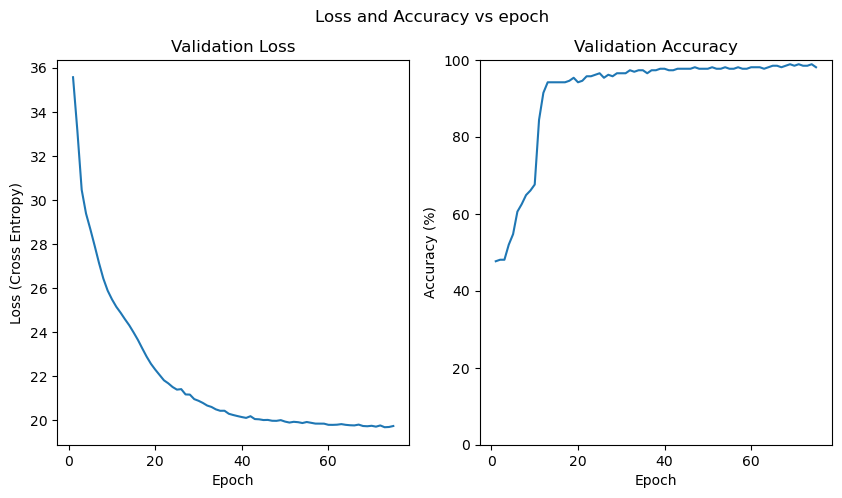

In [24]:
# import csv
loss_hist= []
acc_hist = []

with open(history_da_pth, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row['loss'], row['accuracy'])
        loss_hist.append(row['loss'])
        acc_hist.append(row['accuracy'])

loss_hist = np.array([np.array(loss_hist[i].strip('][').split(', ')) for i in range(len(loss_hist))])
loss_hist = loss_hist.astype(float)[0]
acc_hist = np.array([np.array(acc_hist[i].strip('][').split(', ')) for i in range(len(acc_hist))])
acc_hist = acc_hist.astype(float)[0]

print(type(loss_hist))
print(type(acc_hist))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Loss and Accuracy vs epoch")
ax1.plot(np.arange(1, len(loss_hist)+1, 1), loss_hist)
ax2.plot(np.arange(1, len(loss_hist)+1, 1), acc_hist*100)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (Cross Entropy)')
ax1.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.set_ylim(0, 100)

fig.show()

In [25]:
print('MAX ACC:', np.max(acc_hist)*100)

MAX ACC: 98.828125


# Evaluate Models

In [26]:
# model_dir = '/Users/niccolomeniconi/Dropbox (ASU)/Mac/Documents/Arduino/MFG598_project/main/utils/models'
# best_enc_model =f'best_FCN_{len(GESTURES)}_enc_model.pth'
# best_dec_model = f'best_FCN_{len(GESTURES)}_dec_model.pth' 
# final_enc_model =f'final_FCN_{len(GESTURES)}_enc_model.pth'
# final_dec_model = f'final_FCN_{len(GESTURES)}_dec_model.pth' 
# # window_len=100

# final_enc_pth = f'{model_dir}/{final_enc_model}'
# final_dec_pth = f'{model_dir}/{final_dec_model}'
# best_enc_pth = f'{model_dir}/{best_enc_model}'
# best_dec_pth = f'{model_dir}/{best_dec_model}'
# history_da_pth = f"{model_dir}/FCN_{len(GESTURES)}_model_training_history.csv"
# mean_std_path = f"{model_dir}/mean_and_std_{len(GESTURES)}.csv"

In [27]:
### Load saved models
# model_dir = '/Users/niccolomeniconi/Dropbox (ASU)/Mac/Documents/Arduino/MFG598_project/main/utils/models'
enc_model =f'best_FCN_{len(GESTURES)}_enc_model.pth'
dec_model = f'best_FCN_{len(GESTURES)}_dec_model.pth' 
# window_len=30

enc_pth = f'{model_dir}/{enc_model}'
dec_pth = f'{model_dir}/{dec_model}'
loss_fn = nn.CrossEntropyLoss().to(device)

# >> INPUTS MEAN VECTOR: [0.4479257  0.44617123 0.44681    0.47656862 0.45202429 0.45504038]
# >> INPUTS STD  VECTOR: [0.00018047 0.00061068 0.00020173 0.10195067 0.11586862 0.0963119 ]
# mean_train = np.array([-0.25806828, -0.38594527,  0.73264118,  0.53185828,  0.16251495,  1.60469849])
# std_train  = np.array([0.27707012,  0.46562432,  0.19827382, 23.19193505, 28.79753958, 89.3337316])
# mean_train = np.array([0.4479257,  0.44617123, 0.44681,    0.47656862, 0.45202429, 0.45504038])
# std_train  = np.array([0.00018047, 0.00061068, 0.00020173, 0.10195067, 0.11586862, 0.0963119 ])
max_train=np.array(max)
min_train=np.array(min)


history_da_pth = f"{model_dir}/FCN_{len(GESTURES)}_model_training_history.csv"
print(history_da_pth)
# print(modelpth)

encoder = Encoder1d_conduct(window_len=window_len, verbose=False)
decoder = DecoderLin1d_conduct(window_len=window_len, number_activities=len(GESTURES), verbose=False)
encoder.load_state_dict(torch.load(enc_pth))
decoder.load_state_dict(torch.load(dec_pth))

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

./utils/models/FCN_4_model_training_history.csv


In [28]:
# import torchvision.transforms as transforms
# from torch.autograd import Variable as V

# # normalize = transforms.Normalize(mean=mean_train, std=std_train)

# # mean_train_matrix = np.tile(mean_train, (window_len, 1)).T
# # std_train_matrix = np.tile(std_train, (window_len, 1)).T

inputs, outputs = next(iter(trainloader))
idx = 4
input = np.array(inputs[idx])
output = np.array(outputs[idx])

In [29]:
print(type(output))
print(output.shape)

<class 'numpy.ndarray'>
(4,)


In [30]:
from scipy.special import softmax

In [31]:
### Testing function

def deploy_model(encoder, decoder, device, input, label, loss_fn): 

    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    input_image = torch.from_numpy(input)
    label_gt = torch.from_numpy(label)
    input_image = torch.unsqueeze(input_image, 0)
    label_gt= torch.unsqueeze(label_gt, 0)
    input_image = input_image.type(torch.FloatTensor)

    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        # conc_out = []
        # conc_label = []
        # conc_input = []

        # image_noisy = input_image

        # conc_input.append(image_noisy)
        # # Move tensor to the proper device
        # image_noisy = image_noisy.to(device)
        # # Encode data

        encoded_data = encoder(input_image)
        # Decode data
        label_out = decoder(encoded_data)
        label_out = torch.squeeze(label_out, 1)
        label_output = np.array(label_out.cpu())[0] 
        label_out_softmax = softmax(label_output)
        prediction_idx = np.where(label_out_softmax == np.max(label_out_softmax))


        # Evaluate global loss
        val_loss = loss_fn(label_out, label_gt)  
        

    return prediction_idx, label_out_softmax, label_output, np.array(input_image.cpu())

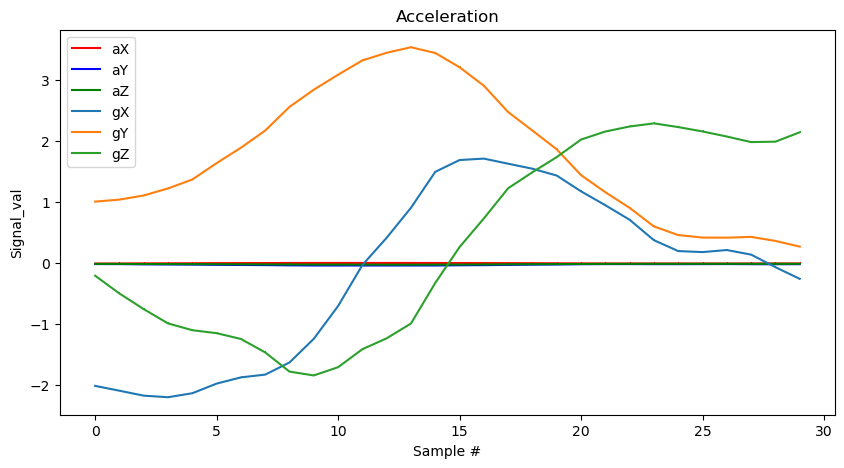

ACTIVITY: [3]


In [32]:
plt.rcParams["figure.figsize"] = (10,5)

plt.plot(input[0], 'r', label='aX', linestyle='solid', marker=',')
plt.plot(input[1], 'b', label='aY', linestyle='solid', marker=',')
plt.plot(input[2], 'g', label='aZ', linestyle='solid', marker=',')
plt.plot(input[3], label='gX', linestyle='solid', marker=',')
plt.plot(input[4], label='gY', linestyle='solid', marker=',')
plt.plot(input[5], label='gZ', linestyle='solid', marker=',')
# plt.plot(index, df['act'], label='act', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Signal_val")
plt.legend()
plt.show()
plt.show()

print("ACTIVITY:", np.where(output==1.)[0])

In [33]:
label_out, label_out_softmax, label_output, _ = deploy_model(encoder, decoder, device, input=input, label=output, loss_fn=loss_fn)
print('PREDICTED ACTIVITY:', label_out[0])

PREDICTED ACTIVITY: [3]
